<a href="https://colab.research.google.com/github/Abhishekcoder711/ClimaView/blob/main/Climate_Predictor_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install meteostat
!pip install dotenv

In [ ]:
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from numpy import sqrt
from sklearn.metrics import mean_squared_error

# Check TensorFlow version to ensure Keras is correctly imported
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [ ]:
# IMPORTANT: OPENWEATHER API KEY
API_KEY = "ba9745e16b50d1578794403871368ba8"

CITY_NAME = "New Delhi" # Example city
BASE_URL = "https://api.openweathermap.org/data/2.5/forecast"
TIME_STEP = 8

def fetch_weather_data(city, api_key):
    print(f"Fetching 5-day / 3-hour forecast data for {city}...")
    params = {
        "q": city,
        "appid": api_key,
        "units": "metric" # Temperature in Celsius
    }
    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status() # Raises an HTTPError for bad responses (4xx or 5xx)
        data = response.json()

        # Extract datetime and temperature
        temp_data = []
        for item in data['list']:
            temp_data.append({
                'datetime': pd.to_datetime(item['dt_txt']),
                'temp': item['main']['temp']
            })

        df = pd.DataFrame(temp_data).set_index('datetime')
        print(f"Total data points fetched: {len(df)}")
        return df['temp'].values.reshape(-1, 1) # Return as a NumPy array (Samples, 1)

    except requests.exceptions.HTTPError as e:
        print(f"\nAPI Error: Could not fetch data. Check API Key or City Name. Error: {e}")
        return None
    except Exception as e:
        print(f"\nAn error occurred during data fetching: {e}")
        return None

temp_series = fetch_weather_data(CITY_NAME, API_KEY)

if temp_series is None:
    print("Stopping script due to data fetching error.")
    exit()

Fetching 5-day / 3-hour forecast data for New Delhi...
Total data points fetched: 40


In [ ]:
# --- NORMALIZATION ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(temp_series)

# --- SEQUENCE CREATION ---
def create_sequences(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

X, Y = create_sequences(scaled_data, TIME_STEP)

X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

print(f"Training Input Shape (X_train): {X_train.shape}")

Training Input Shape (X_train): (25, 8, 1)


In [ ]:
# --- MODEL ARCHITECTURE ---
model = Sequential()
# First LSTM layer: returns sequences for the next LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(TIME_STEP, 1)))
model.add(Dropout(0.2))

# Second LSTM layer: only returns the final output
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output Dense Layer (1 unit for predicting a single temperature value)
model.add(Dense(units=1))

# Compile: Use Adam optimizer and Mean Squared Error (MSE) for regression
model.compile(optimizer='adam', loss='mean_squared_error')

# --- MODEL TRAINING ---
print("\n--- Starting LSTM Model Training ---")
history = model.fit(
    X_train, Y_train,
    epochs=50, # You can increase epochs for better training
    batch_size=32,
    verbose=1,
    validation_split=0.1 # Use 10% of training data for validation
)
print("--- LSTM Model Training Complete ---")


--- Starting LSTM Model Training ---
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.2795 - val_loss: 0.4628
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - loss: 0.2476 - val_loss: 0.4248
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2260 - val_loss: 0.3874
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2096 - val_loss: 0.3505
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 0.1881 - val_loss: 0.3140
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - loss: 0.1606 - val_loss: 0.2781
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1510 - val_loss: 0.2433
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1321 - val_loss: 0.2105
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.1200 - val_loss: 0.1811
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 0.1044 - val_loss: 0.1573
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.1119 - val_loss: 0.1409
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.1050 - val_loss: 0.1318
Epoch

In [ ]:
# --- PREDICTION ---
predicted_scaled = model.predict(X_test)

# --- INVERSE TRANSFORM (Scale back to Celsius) ---
predicted_temp = scaler.inverse_transform(predicted_scaled)

# Actual values ko Celsius
actual_temp_scaled = Y_test.reshape(-1, 1)
actual_temp = scaler.inverse_transform(actual_temp_scaled)

# --- EVALUATION (RMSE) ---
rmse = sqrt(mean_squared_error(actual_temp, predicted_temp))

print("\n================ RESULTS ================")
print(f"Test Data for RMSE (Root Mean Square Error): {rmse:.2f} °C")
print("How much RMSE is less then model is good.")
print("=========================================")

# --- SAMPLE RESULTS ---
results_df = pd.DataFrame({
    'Actual Temp (°C)': actual_temp.flatten(),
    'Predicted Temp (°C)': predicted_temp.flatten()
})

print("\nFirst 10 Predictions vs. Actual:")
print(results_df.head(10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step

================ RESULTS ================
Test Data for RMSE (Root Mean Square Error): 2.30 °C
How much RMSE is less then model is good.

First 10 Predictions vs. Actual:
   Actual Temp (°C)  Predicted Temp (°C)
0             32.45            29.302099
1             30.41            29.059025
2             28.87            29.014063
3             27.10            29.175795
4             26.08            29.465616
5             27.28            29.845755
6             31.79            30.065218


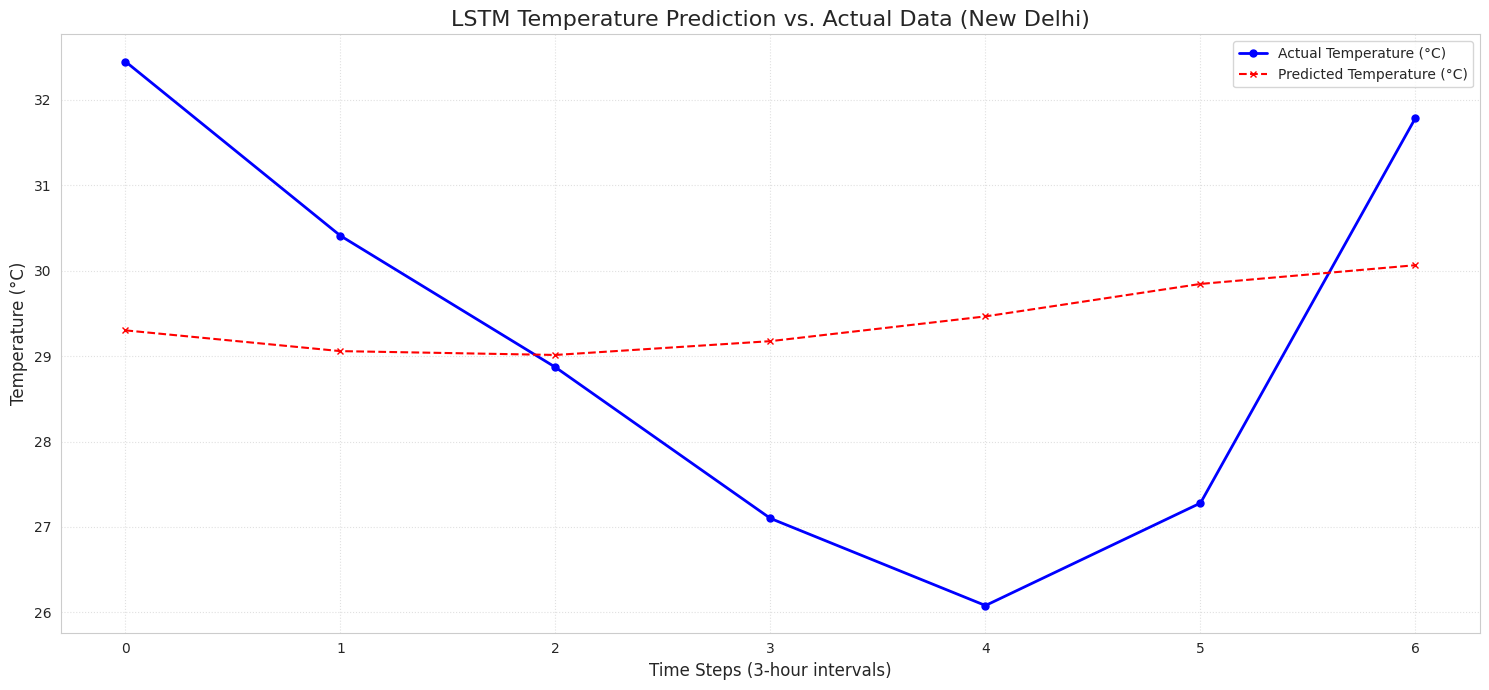

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

actual_temp_flat = actual_temp.flatten()
predicted_temp_flat = predicted_temp.flatten()

time_steps = np.arange(len(actual_temp_flat))


plt.figure(figsize=(15, 7))

plt.plot(time_steps, actual_temp_flat,
         label='Actual Temperature (°C)',
         color='blue',
         linewidth=2,
         marker='o',
         markersize=5,
         markevery=1
        )

plt.plot(time_steps, predicted_temp_flat,
         label='Predicted Temperature (°C)',
         color='red',
         linestyle='--',
         linewidth=1.5,
         marker='x',
         markersize=5,
         markevery=1
        )


plt.title(f'LSTM Temperature Prediction vs. Actual Data ({CITY_NAME})', fontsize=16)
plt.xlabel('Time Steps (3-hour intervals)', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

In [ ]:
import requests
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- CONFIGURATION ---
# IMPORTANT: PASTE YOUR OPENWEATHER API KEY HERE
API_KEY = "ba9745e16b50d1578794403871368ba8"
CITY_NAME = "New Delhi"
BASE_URL = "https://api.openweathermap.org/data/2.5/forecast"

# Parameters
TIME_STEP = 8  # Use 8 previous 3-hour readings (24 hours) for input
FUTURE_STEPS = 10 # Predict next 10 time steps (30 hours)

In [ ]:
# --- DATA FETCHING ---
def fetch_weather_data(city, api_key):
    print(f"Fetching 5-day / 3-hour forecast data for {city}...")
    params = {
        "q": city,
        "appid": api_key,
        "units": "metric"
    }
    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()

        temp_data = []
        for item in data['list']:
            temp_data.append({
                'datetime': pd.to_datetime(item['dt_txt']),
                'temp': item['main']['temp']
            })

        df = pd.DataFrame(temp_data).set_index('datetime')
        print(f"Total data points fetched: {len(df)}")

        # --- RETURN STATEMENT MODIFIED: df ko bhi return kiya gaya hai ---
        return df['temp'].values.reshape(-1, 1), df.index, df

    except requests.exceptions.HTTPError as e:
        print(f"\nAPI Error: Check API Key or City Name. Error: {e}")
        # Error hone par teen None return ho rahe hain
        return None, None, None # MODIFIED
    except Exception as e:
        print(f"\nAn error occurred during data fetching: {e}")
        return None, None, None # MODIFIED

# --- FUNCTION CALL MODIFIED: df ko receive karne ke liye naya variable ---
temp_series, dates, df = fetch_weather_data(CITY_NAME, API_KEY)

if temp_series is None:
    print("Stopping script.")
    exit()

print("\n--- Fetched and Structured Data (First 5 and Last 5 Rows) ---")
print(df.head())
print(df.tail())
print("----------------------------------------------------------")

# --- NORMALIZATION ---
scaler = MinMaxScaler(feature_range=(0, 1)) # MinMax Scaler
scaled_data = scaler.fit_transform(temp_series)

# --- SEQUENCE CREATION (Multi-Step Output) ---
def create_sequences_multi_step(data, time_step, future_steps):
    X, Y = [], []
    for i in range(len(data) - time_step - future_steps + 1):
        # Input (X): Previous 'time_step' values
        X.append(data[i:(i + time_step), 0])
        # Output (Y): Next 'future_steps' values
        Y.append(data[(i + time_step):(i + time_step + future_steps), 0])
    return np.array(X), np.array(Y)

X, Y = create_sequences_multi_step(scaled_data, TIME_STEP, FUTURE_STEPS)

X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.8)
X_train, Y_train = X[:train_size], Y[:train_size]

print(f"Training Input Shape (X_train): {X_train.shape}")

Fetching 5-day / 3-hour forecast data for New Delhi...
Total data points fetched: 40

--- Fetched and Structured Data (First 5 and Last 5 Rows) ---
                      temp
datetime                  
2025-10-15 09:00:00  31.02
2025-10-15 12:00:00  30.98
2025-10-15 15:00:00  29.45
2025-10-15 18:00:00  27.99
2025-10-15 21:00:00  26.55
                      temp
datetime                  
2025-10-19 18:00:00  28.98
2025-10-19 21:00:00  27.22
2025-10-20 00:00:00  26.31
2025-10-20 03:00:00  27.50
2025-10-20 06:00:00  31.87
----------------------------------------------------------
Training Input Shape (X_train): (18, 8, 1)


In [ ]:
# --- MODEL ARCHITECTURE ---
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(TIME_STEP, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output Dense Layer: FUTURE_STEPS (10) units honge
model.add(Dense(units=FUTURE_STEPS))

# Compile: Loss function simple rakhenge
model.compile(optimizer='adam', loss='mae') # Mean Absolute Error (MAE) used for simplicity

# --- MODEL TRAINING ---
print("\n--- Starting LSTM Model Training ---")
model.fit(
    X_train, Y_train,
    epochs=100, # More epochs for better results
    batch_size=32,
    verbose=0 # Training output silent rakhenge
)
print("--- LSTM Model Training Complete ---")

# --- FINAL 10-DAY PREDICTION ---

last_sequence = scaled_data[-TIME_STEP:].reshape(1, TIME_STEP, 1)

predicted_scaled = model.predict(last_sequence)

# Predictions ko wapas original scale (Celsius) mein laana
predicted_temp = scaler.inverse_transform(predicted_scaled).flatten()

print(f"\n--- Agle 10 Time Steps ({FUTURE_STEPS} x 3 hours) ka Prediction ---\n")
for i, temp in enumerate(predicted_temp):
    print(f"Time Step T+{i+1}: {temp:.2f} °C")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- Starting LSTM Model Training ---
--- LSTM Model Training Complete ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step

--- Agle 10 Time Steps (10 x 3 hours) ka Prediction ---

Time Step T+1: 33.04 °C
Time Step T+2: 34.05 °C
Time Step T+3: 32.81 °C
Time Step T+4: 29.97 °C
Time Step T+5: 27.59 °C
Time Step T+6: 26.26 °C
Time Step T+7: 26.76 °C
Time Step T+8: 30.20 °C
Time Step T+9: 32.28 °C
Time Step T+10: 33.45 °C


/tmp/ipython-input-2928703349.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  future_time_deltas = pd.to_timedelta(np.arange(1, FUTURE_STEPS + 1) * 3, unit='H')


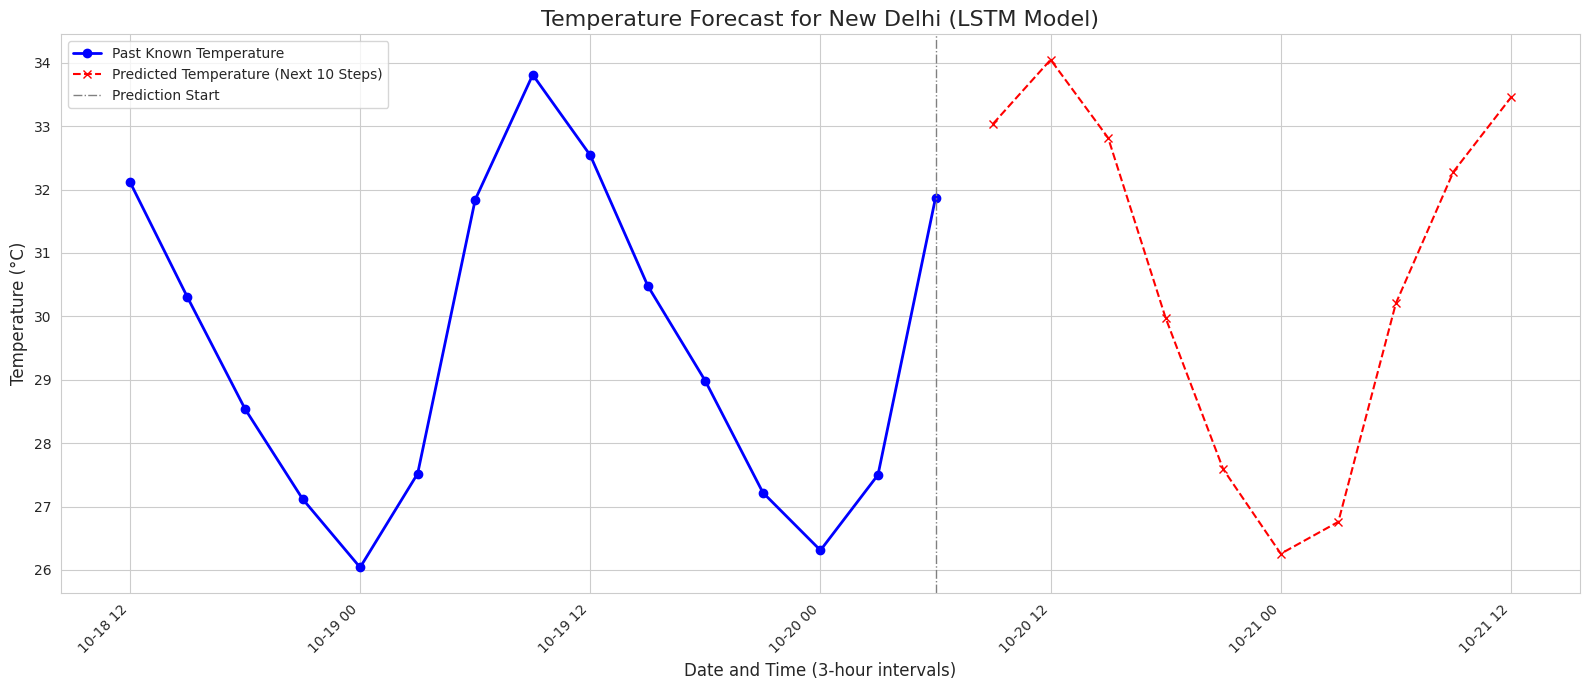

In [ ]:
# --- GRAPH VISUALIZATION ---

KNOWN_HISTORY_POINTS = 15
history_temp = temp_series[-KNOWN_HISTORY_POINTS:].flatten()
history_dates = dates[-KNOWN_HISTORY_POINTS:]

last_known_dt = dates[-1]
future_time_deltas = pd.to_timedelta(np.arange(1, FUTURE_STEPS + 1) * 3, unit='H')
future_dates = last_known_dt + future_time_deltas

# Combined Plotting: Historical and Predicted
plt.figure(figsize=(16, 7))
sns.set_style("whitegrid")

# Historical Data Plot (Blue Line)
plt.plot(history_dates, history_temp,
         label='Past Known Temperature',
         color='blue',
         marker='o',
         linewidth=2)

# Predicted Data Plot (Red Dashed Line)
plt.plot(future_dates, predicted_temp,
         label=f'Predicted Temperature (Next {FUTURE_STEPS} Steps)',
         color='red',
         marker='x',
         linestyle='--',
         linewidth=1.5)

# Prediction starting point ko highlight karna
plt.axvline(x=last_known_dt, color='gray', linestyle='-.', linewidth=1, label='Prediction Start')

plt.title(f'Temperature Forecast for {CITY_NAME} (LSTM Model)', fontsize=16)
plt.xlabel('Date and Time (3-hour intervals)', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(fontsize=10)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()